## 导入包和数据

In [1]:
from VE_LSH import LSH
from CF import CF
from vector_encrypt import vector_encrypt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from laplace_dp import laplace_dp
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

original_data = pd.read_table('../GIS_LSH_VE_CF/data/train.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
user_mx = pd.read_table('../GIS_LSH_VE_CF/data/user_mx.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
test_data = pd.read_table('../GIS_LSH_VE_CF/data/new_test.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
attack_data = pd.read_table('../GIS_LSH_VE_CF/data/attack_data.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
noisy_user_mx = pd.read_table('../GIS_LSH_VE_CF/data/noisy_data_user_mx.csv',sep=",",names=['latitude','longitude'],encoding='latin-1',engine='python')
data = test_data.groupby(test_data.index).mean()
# data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,0,0
# data = pd.read_table('./GIS_LSH_VE_CF/data/predict_data.csv',sep=",",names=['latitude','longitude','predict_latitude','predict_longitude','la_MAE','long_MAE'],encoding='latin-1',engine='python')
# print(data)
# 对用户矩阵进行预处理，将str转换为list
def to_list(str):
    return [ float(x) for x in str[1:-2].split(',')]
user_mx['latitude'] = user_mx['latitude'].apply(to_list)
user_mx['longitude'] = user_mx['longitude'].apply(to_list)
noisy_user_mx['latitude'] = noisy_user_mx['latitude'].apply(to_list)
noisy_user_mx['longitude'] = noisy_user_mx['longitude'].apply(to_list)

## 训练函数

In [2]:
def train_LSH(test_data,te_lshTable,lshTable,dp_lsh=False,is_laplace = False): 
    global data,lsh_cal
    testIndex = test_data.index
    topk,count,length,num = 3,0,len(testIndex),-1
    # print("测试集LSH为:",lsh_cal.lsh_detect(te_lshTable))
    # print("训练集集LSH为:",lsh_cal.lsh_detect(lshTable))
    start_time = time.time()
    for table_num in te_lshTable.values(): # 遍历测试集的每个表,这里默认设置的一个表
        num += 1
        print("当前表数为:",num)
        for buckets in table_num: # 遍历当前表的hash桶
            if buckets not in lshTable[num].keys():
                    continue
            for test_id in te_lshTable[num][buckets]: # 遍历当前表当前桶里的测试集用户和训练集用户
                count += 1
                #print("当前进度是:",count/length)
                sim_lis = []
                
                for train_id in lshTable[num][buckets]: # 遍历训练集hash映射后同一个表，同一个桶下的数据
                    sim_lis.append(lsh_cal.calSim(test_id,train_id,is_laplace))
                te = sorted(sim_lis,key=lambda x:x[1],reverse=True)[2:topk]
                lsh_cal.lsh_mae(test_id,te)
    end_time = time.time()
    la_mae,long_mae = data['la_MAE'].mean(),data['long_MAE'].mean()
    if(dp_lsh):
        mean_mae = (la_mae+long_mae)/2 + np.random.laplace(0, 1/10, 1)
    else:
         mean_mae = (la_mae+long_mae)/2
    print('测试集long_mae为{0},测试集la_mae为{1},测试集mean_mae为{2}'.format(long_mae,la_mae,mean_mae))
    return mean_mae,end_time-start_time

In [3]:
def train_CF(train_data,test_data):
    global data,cf_cal
    trainIndex,testIndex,topk,count = train_data.index,test_data.index,3,0
    length = len(testIndex)
    start_time = time.time()
    for i in testIndex:
        count += 1
        #print("当前进度是:",count/length)
        sim_lis = []
        for j in trainIndex:
            if i == j:
                continue
            sim_lis.append(cf_cal.calSim(i,j))
        te = sorted(sim_lis,key=lambda x:x[1],reverse=True)[1:topk]
        cf_cal.cf_mae(i,te)
    end_time = time.time()
    la_mae,long_mae = data['la_MAE'].mean(),data['long_MAE'].mean()
    mean_mae = (la_mae+long_mae)/2
    print('测试集long_mae为{0},测试集la_mae为{1},测试集mean_mae为{2}'.format(long_mae,la_mae,mean_mae))
    return mean_mae,end_time-start_time

In [4]:
def train_encrypt_LSH(test_data,te_lshTable,lshTable):
    global data,lsh_cal
    testIndex = test_data.index
    topk,count,length,num = 3,0,len(testIndex),-1
    # print("测试集LSH为:",lsh_cal.lsh_detect(te_lshTable))
    # print("训练集集LSH为:",lsh_cal.lsh_detect(lshTable))
    res_time = 0
    start_time = time.time()
    for table_num in te_lshTable.values(): # 遍历测试集的每个表,这里默认设置的一个表
        num += 1
        print("当前表数为:",num)
        for buckets in table_num: # 遍历当前表的hash桶
            if buckets not in lshTable[num].keys():
                    continue
            for test_id in te_lshTable[num][buckets]: # 遍历当前表当前桶里的测试集用户和训练集用户
                count += 1
                #print("当前进度是:",count/length)
                sim_lis = []
                end_time = time.time()
                res_time += end_time-start_time
                for train_id in lshTable[num][buckets]: # 遍历训练集hash映射后同一个表，同一个桶下的数据
                    sim_res,time_count = lsh_cal.encrypt_calSim(test_id,train_id)
                    res_time += time_count
                    sim_lis.append(sim_res)
                start_time = time.time()
                te = sorted(sim_lis,key=lambda x:x[1],reverse=True)[2:topk]
                lsh_cal.lsh_mae(test_id,te)
                end_time = time.time()
                res_time += end_time-start_time
    la_mae,long_mae = data['la_MAE'].mean(),data['long_MAE'].mean()
    mean_mae = (la_mae+long_mae)/2
    print('测试集long_mae为{0},测试集la_mae为{1},测试集mean_mae为{2}'.format(long_mae,la_mae,mean_mae))
    return mean_mae,res_time

## 参数和实例化

In [5]:
data_item = [2000,4000,6000,8000,10000]
attack_data_item = [1000,2000,3000,4000,5000]
# 参数设置
mae,times = [],[]
nbits,num,d = 20,2,2
# 实例化
vec_encrypt = vector_encrypt()
laplaceDP = laplace_dp()
lsh_cal = LSH(user_mx,data,vec_encrypt,laplaceDP)
cf_cal = CF(user_mx,data)
times = {}
bits_dic = {}
hash_func = lsh_cal.hash_function(num,nbits,d) # hash映射函数
for i in range(5):
    bits_dic[i],times[i] = [],[]

# 隐私保护性能对比

## 参数和实例化

In [6]:
data_item = [10000]
attack_data_item = [1000,2000,3000,4000,5000]
# 参数设置
mae,times = [],[]
nbits,num,d = 20,2,2
# 实例化
vec_encrypt = vector_encrypt()
laplaceDP = laplace_dp()
lsh_cal = LSH(noisy_user_mx,data,vec_encrypt,laplaceDP)
cf_cal = CF(noisy_user_mx,data)
times = {}
bits_dic = {}
hash_func = lsh_cal.hash_function(num,nbits,d) # hash映射函数
for i in range(4):
    bits_dic[i],times[i] = [],[]

## Paillier_CF

In [29]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0, 0
for i in attack_data_item:
    print("当前数据切片是:",i)
    df1 = original_data.iloc[i:10000]
    df2 = attack_data.iloc[0:i]
    train_data = pd.concat([df1,df2]) # 拼接恶意数据
    cf_mean_mae,cf_time = train_CF(train_data,test_data)
    total_time += cf_time
    bits_dic[0].append(cf_mean_mae),times[0].append(total_time)

当前数据切片是: 1000
测试集long_mae为8.327753929323615,测试集la_mae为2.8098442494057663,测试集mean_mae为5.56879908936469
当前数据切片是: 2000
测试集long_mae为8.209705418635856,测试集la_mae为2.7548097132445175,测试集mean_mae为5.482257565940187
当前数据切片是: 3000
测试集long_mae为8.065605242259002,测试集la_mae为2.692213700541922,测试集mean_mae为5.378909471400462
当前数据切片是: 4000
测试集long_mae为7.870862916442341,测试集la_mae为2.6097363919881253,测试集mean_mae为5.240299654215233
当前数据切片是: 5000
测试集long_mae为7.357566049445654,测试集la_mae为2.398738386483833,测试集mean_mae为4.878152217964743


## LDP_LSH

In [23]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in attack_data_item:
    print("当前数据切片是:",i)
    df1 = original_data.iloc[i:2000]
    df2 = attack_data[0:i]
    train_data = pd.concat([df1,df2])
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_mae,lsh_time = train_LSH(train_data,te_lshTable,lshTable,False,True)
    total_time += lsh_time
    bits_dic[1].append(lsh_mae),times[1].append(total_time)

当前数据切片是: 200
当前表数为: 0
当前表数为: 1
测试集long_mae为7.320736257371001,测试集la_mae为1.7773619380560002,测试集mean_mae为4.5490490977135005
当前数据切片是: 400
当前表数为: 0
当前表数为: 1
测试集long_mae为4.801031457459499,测试集la_mae为1.0534990702589997,测试集mean_mae为2.9272652638592493
当前数据切片是: 600
当前表数为: 0
当前表数为: 1
测试集long_mae为3.474546830828,测试集la_mae为0.6132124593274996,测试集mean_mae为2.04387964507775
当前数据切片是: 800
当前表数为: 0
当前表数为: 1
测试集long_mae为3.0688108350610004,测试集la_mae为0.41467014116550005,测试集mean_mae为1.7417404881132503
当前数据切片是: 1000
当前表数为: 0
当前表数为: 1
测试集long_mae为2.6528234061704996,测试集la_mae为0.2913038660705003,测试集mean_mae为1.4720636361205


## FRec_LSH

In [24]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in attack_data_item:
    print("当前数据切片是:",i)
    df1 = original_data.iloc[i:2000]
    df2 = attack_data[0:i]
    train_data = pd.concat([df1,df2])
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_mae,lsh_time = train_LSH(train_data,te_lshTable,lshTable,True,False)
    total_time += lsh_time
    bits_dic[2].append(lsh_mae),times[2].append(total_time)

当前数据切片是: 200
当前表数为: 0
当前表数为: 1
测试集long_mae为4.096562682866498,测试集la_mae为0.8604545458345001,测试集mean_mae为[2.42658002]
当前数据切片是: 400
当前表数为: 0
当前表数为: 1
测试集long_mae为3.825450771020998,测试集la_mae为0.7589205154625001,测试集mean_mae为[2.24540261]
当前数据切片是: 600
当前表数为: 0
当前表数为: 1
测试集long_mae为3.801013583313499,测试集la_mae为0.7488893417954998,测试集mean_mae为[2.23468809]
当前数据切片是: 800
当前表数为: 0
当前表数为: 1
测试集long_mae为3.5360789982669987,测试集la_mae为0.6348361043569998,测试集mean_mae为[2.09016991]
当前数据切片是: 1000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.3357379779494987,测试集la_mae为0.5500225465329995,测试集mean_mae为[2.01627461]


## IVE_LSH

In [25]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in attack_data_item:
    print("当前数据切片是:",i)
    df1 = original_data.iloc[i:2000]
    df2 = attack_data[0:i]
    train_data = pd.concat([df1,df2])
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_encrypt_mae,lsh_encrypt_time = train_encrypt_LSH(test_data,te_lshTable,lshTable)
    total_time += lsh_encrypt_time
    bits_dic[3].append(lsh_encrypt_mae),times[3].append(total_time)


当前数据切片是: 200
当前表数为: 0
当前表数为: 1
测试集long_mae为4.096562682866499,测试集la_mae为0.8604545458345004,测试集mean_mae为2.4785086143504995
当前数据切片是: 400
当前表数为: 0
当前表数为: 1
测试集long_mae为3.825450771020998,测试集la_mae为0.7589205154625001,测试集mean_mae为2.292185643241749
当前数据切片是: 600
当前表数为: 0
当前表数为: 1
测试集long_mae为3.801013583313499,测试集la_mae为0.7488893417955,测试集mean_mae为2.2749514625544993
当前数据切片是: 800
当前表数为: 0
当前表数为: 1
测试集long_mae为3.5360789982669996,测试集la_mae为0.6348361043569998,测试集mean_mae为2.0854575513119995
当前数据切片是: 1000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.3357379779494987,测试集la_mae为0.5500225465329998,测试集mean_mae为1.9428802622412493


In [26]:
print("各个算法的误差为:{0}\n各个所用的时间为{1}".format(bits_dic,times))

各个算法的误差为:{0: [3.1518851710481193, 2.843599565208061, 2.6301907769670767, 2.4379164666443724, 2.0542303080425173], 1: [4.5490490977135005, 2.9272652638592493, 2.04387964507775, 1.7417404881132503, 1.4720636361205], 2: [array([2.42658002]), array([2.24540261]), array([2.23468809]), array([2.09016991]), array([2.01627461])], 3: [2.4785086143504995, 2.292185643241749, 2.2749514625544993, 2.0854575513119995, 1.9428802622412493]}
各个所用的时间为{0: [31.79244327545166, 69.76707315444946, 108.63836359977722, 142.906982421875, 162.51672172546387], 1: [3.3745346069335938, 6.23119854927063, 8.676803350448608, 10.644214153289795, 12.281527280807495], 2: [2.854539632797241, 5.345520734786987, 7.464233636856079, 9.224400043487549, 10.649658441543579], 3: [4.357374668121338, 8.026156187057495, 11.060027599334717, 13.679992198944092, 15.785820245742798]}


各个算法的误差为:{0: [3.1518851710481193, 2.843599565208061, 2.6301907769670767, 2.4379164666443724, 2.0542303080425173], 1: [4.5490490977135005, 2.9272652638592493, 2.04387964507775, 1.7417404881132503, 1.4720636361205], 2: [array([2.42658002]), array([2.24540261]), array([2.23468809]), array([2.09016991]), array([2.01627461])], 3: [2.4785086143504995, 2.292185643241749, 2.2749514625544993, 2.0854575513119995, 1.9428802622412493]}
各个所用的时间为{0: [31.79244327545166, 69.76707315444946, 108.63836359977722, 142.906982421875, 162.51672172546387], 1: [3.3745346069335938, 6.23119854927063, 8.676803350448608, 10.644214153289795, 12.281527280807495], 2: [2.854539632797241, 5.345520734786987, 7.464233636856079, 9.224400043487549, 10.649658441543579], 3: [4.357374668121338, 8.026156187057495, 11.060027599334717, 13.679992198944092, 15.785820245742798]}


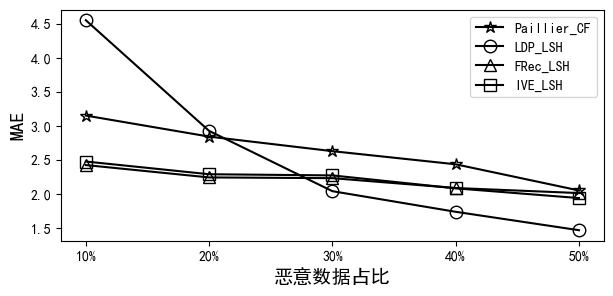

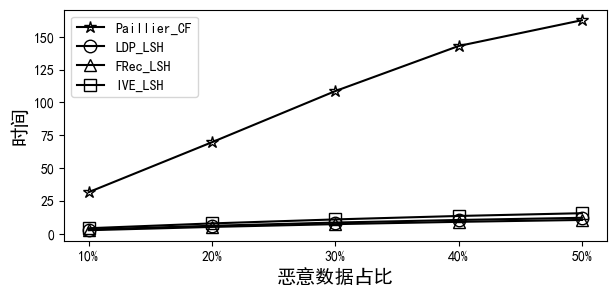

In [27]:
leg = []
data_item = ['10%','20%','30%','40%','50%']
leg.append("Paillier_CF"),leg.append("LDP_LSH"),leg.append("FRec_LSH"),leg.append("IVE_LSH")
print("各个算法的误差为:{0}\n各个所用的时间为{1}".format(bits_dic,times))

style = ["*","o","^","s","X","<",">","p","h","1","2"]
plt.figure(1 , figsize = (7 , 3) )
for i in range(4):
    plt.plot(data_item,bits_dic[i],color='k',marker=style[i],markersize=9,markerfacecolor='none')
plt.xlabel("恶意数据占比",fontsize=14),plt.ylabel("MAE",fontsize=14),plt.legend(leg)
fig=plt.gcf()
fig.savefig('../GIS_LSH_VE_CF/bw_picture//attack_cmp_mae.jpg', bbox_inches='tight', pad_inches=0,dpi=500)

plt.figure(2 , figsize = (7 , 3) )
for i in range(4):
    plt.plot(data_item,times[i],color='k',marker=style[i],markersize=9,markerfacecolor='none')
plt.xlabel("恶意数据占比",fontsize=14),plt.ylabel("时间",fontsize=14),plt.legend(leg)
fig=plt.gcf()
fig.savefig('../GIS_LSH_VE_CF/bw_picture//attack_cmp_time.jpg',bbox_inches='tight', pad_inches=0,dpi=500)
plt.show()

各个算法的误差为:{0: [6.255818920201389, 6.068192853773357, 5.712800743332887, 5.24988997912535, 4.8929030738736925], 1: [5.184470749225724, 2.72528981120675, 1.7148116514201748, 1.2762809388913499, 0.9955994893514999], 2: [array([5.40186584]), array([4.67849389]), array([4.43627639]), array([4.09183503]), array([3.66839446])], 3: [5.6137829898908755, 5.1987597207619, 4.77426144812355, 4.34730416765655, 3.9694839137328497]}
各个所用的时间为{0: [2004.5645380020142, 4028.8024406433105, 6072.816443681717, 8064.444778203964, 10025.005819797516], 1: [627.5705826282501, 1192.843421459198, 1736.0913791656494, 2212.7878003120422, 2639.875956296921], 2: [509.7284643650055, 963.6719717979431, 1374.0030553340912, 1747.7923092842102, 2054.6035828590393], 3: [621.3995916843414, 1184.1282932758331, 1700.0774335861206, 2154.1801013946533, 2536.650682926178]}


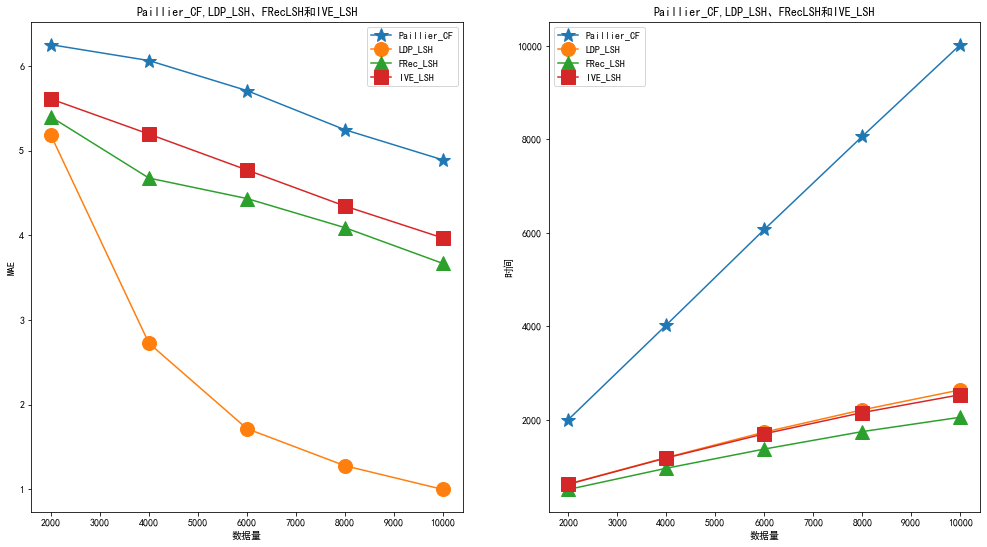

In [49]:
leg = []
leg.append("Paillier_CF"),leg.append("LDP_LSH"),leg.append("FRec_LSH"),leg.append("IVE_LSH")
print("各个算法的误差为:{0}\n各个所用的时间为{1}".format(bits_dic,times))

style = ["*","o","^","s","X","<",">","p","h","1","2"]
plt.figure(1 , figsize = (17 , 9) )
plt.subplot(121)
for i in range(4):
    plt.plot(data_item,bits_dic[i],marker=style[i],markersize=14)
plt.xlabel("数据量"),plt.ylabel("MAE"),plt.title("Paillier_CF,LDP_LSH、FRecLSH和IVE_LSH"),plt.legend(leg)

plt.subplot(122)
for i in range(4):
    plt.plot(data_item,times[i],marker=style[i],markersize=14)
plt.xlabel("数据量"),plt.ylabel("时间"),plt.title("Paillier_CF,LDP_LSH、FRecLSH和IVE_LSH"),plt.legend(leg)
fig=plt.gcf()
fig.savefig('../GIS_LSH_VE_CF/picture//attack_cmp.jpg',dpi=500)
plt.show()

# 推荐效果性能对比

## 参数和实例化

In [8]:
data_item = [2000,4000,6000,8000,10000]
attack_data_item = [1000,2000,3000,4000,5000]
# 参数设置
mae,times = [],[]
nbits,num,d = 20,2,2
# 实例化
vec_encrypt = vector_encrypt()
laplaceDP = laplace_dp()
lsh_cal = LSH(user_mx,data,vec_encrypt,laplaceDP)
cf_cal = CF(user_mx,data)
times = {}
bits_dic = {}
hash_func = lsh_cal.hash_function(num,nbits,d) # hash映射函数
for i in range(5):
    bits_dic[i],times[i] = [],[]

## Paillier_CF

In [8]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0, 0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    cf_mean_mae,cf_time = train_CF(train_data,test_data)
    total_time += cf_time
    bits_dic[0].append(cf_mean_mae),times[0].append(total_time)
    start = 0

当前数据切片是: 2000
测试集long_mae为4.737426896961466,测试集la_mae为1.7306761635535803,测试集mean_mae为3.2340515302575232
当前数据切片是: 4000
测试集long_mae为3.2305083004542507,测试集la_mae为1.080545319897048,测试集mean_mae为2.1555268101756493
当前数据切片是: 6000
测试集long_mae为2.145888048832922,测试集la_mae为0.6827692558546207,测试集mean_mae为1.4143286523437713
当前数据切片是: 8000
测试集long_mae为1.9467467422230242,测试集la_mae为0.6041138266734066,测试集mean_mae为1.2754302844482155
当前数据切片是: 10000
测试集long_mae为1.8217924501721785,测试集la_mae为0.5358235293917566,测试集mean_mae为1.1788079897819674


## 加入laplace噪声LDPLSH

In [10]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_mae,lsh_time = train_LSH(train_data,te_lshTable,lshTable,False,True)
    total_time += lsh_time
    bits_dic[1].append(lsh_mae),times[1].append(total_time)
    start = 0

当前数据切片是: 2000
当前表数为: 0
当前表数为: 1
测试集long_mae为11.1985639378145,测试集la_mae为2.9659597047494994,测试集mean_mae为7.082261821282
当前数据切片是: 4000
当前表数为: 0
当前表数为: 1
测试集long_mae为4.6297507451065,测试集la_mae为1.3443910828749994,测试集mean_mae为2.9870709139907494
当前数据切片是: 6000
当前表数为: 0


KeyboardInterrupt: 

In [9]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num,True) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_mae,lsh_time = train_LSH(train_data,te_lshTable,lshTable,False,True)
    total_time += lsh_time
    bits_dic[1].append(lsh_mae),times[1].append(total_time)
    start = 0

当前数据切片是: 2000
当前表数为: 0
当前表数为: 1
测试集long_mae为88.88004953002851,测试集la_mae为32.0458055813235,测试集mean_mae为60.462927555676
当前数据切片是: 4000
当前表数为: 0
当前表数为: 1
测试集long_mae为87.2752404194135,测试集la_mae为31.883143117253997,测试集mean_mae为59.57919176833375
当前数据切片是: 6000
当前表数为: 0
当前表数为: 1
测试集long_mae为87.20642119442451,测试集la_mae为31.8073842957265,测试集mean_mae为59.50690274507551
当前数据切片是: 8000
当前表数为: 0
当前表数为: 1
测试集long_mae为87.20215538953751,测试集la_mae为31.804046735195,测试集mean_mae为59.503101062366255
当前数据切片是: 10000
当前表数为: 0
当前表数为: 1
测试集long_mae为87.19810364842252,测试集la_mae为31.8039581451085,测试集mean_mae为59.501030896765506


## FRecLSH

In [10]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_mae,lsh_time = train_LSH(train_data,te_lshTable,lshTable,True,False)
    total_time += lsh_time
    bits_dic[2].append(lsh_mae),times[2].append(total_time)
    start = 0

当前数据切片是: 2000
当前表数为: 0
当前表数为: 1
测试集long_mae为2.9467768058919974,测试集la_mae为1.3947211303945,测试集mean_mae为[2.15012596]
当前数据切片是: 4000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.6170033944179982,测试集la_mae为1.8972449360185002,测试集mean_mae为[2.81994331]
当前数据切片是: 6000
当前表数为: 0
当前表数为: 1
测试集long_mae为5.6434879858525,测试集la_mae为2.6152091586099995,测试集mean_mae为[4.14178147]
当前数据切片是: 8000
当前表数为: 0
当前表数为: 1
测试集long_mae为4.597243807345501,测试集la_mae为2.1573339788239996,测试集mean_mae为[3.21213672]
当前数据切片是: 10000
当前表数为: 0
当前表数为: 1
测试集long_mae为4.459685702815002,测试集la_mae为2.0135778412729994,测试集mean_mae为[3.12709047]


## LSH

In [11]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_mae,lsh_time = train_LSH(train_data,te_lshTable,lshTable,True,False)
    total_time += lsh_time
    bits_dic[3].append(lsh_mae),times[3].append(total_time)
    start = 0

当前数据切片是: 2000
当前表数为: 0
当前表数为: 1
测试集long_mae为2.9467768058919974,测试集la_mae为1.3947211303945,测试集mean_mae为[1.94452663]
当前数据切片是: 4000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.6170033944179982,测试集la_mae为1.8972449360185002,测试集mean_mae为[2.79100318]
当前数据切片是: 6000
当前表数为: 0
当前表数为: 1
测试集long_mae为5.6434879858525,测试集la_mae为2.6152091586099995,测试集mean_mae为[4.05445189]
当前数据切片是: 8000
当前表数为: 0
当前表数为: 1
测试集long_mae为4.597243807345501,测试集la_mae为2.1573339788239996,测试集mean_mae为[3.09177453]
当前数据切片是: 10000
当前表数为: 0
当前表数为: 1
测试集long_mae为4.459685702815002,测试集la_mae为2.0135778412729994,测试集mean_mae为[3.24659435]


## IVE_LSH

In [12]:
data['predict_latitude'],data['predict_longitude'],data['la_MAE'],data['long_MAE'] = 0,0,data['latitude'],data['longitude'].abs()
start,total_time = 0,0
for i in data_item:
    print("当前数据切片是:",i)
    train_data = original_data.iloc[start:i]
    lshTable = lsh_cal.lsh_table(train_data,hash_func,nbits,num) # 构建hash表
    te_lshTable = lsh_cal.lsh_table(test_data,hash_func,nbits,num)

    lsh_encrypt_mae,lsh_encrypt_time = train_encrypt_LSH(test_data,te_lshTable,lshTable)
    total_time += lsh_encrypt_time
    bits_dic[4].append(lsh_encrypt_mae),times[4].append(total_time)
    start = 0


当前数据切片是: 2000
当前表数为: 0
当前表数为: 1
测试集long_mae为2.9467768058919988,测试集la_mae为1.3947211303945,测试集mean_mae为2.1707489681432492
当前数据切片是: 4000
当前表数为: 0
当前表数为: 1
测试集long_mae为3.6170033944179982,测试集la_mae为1.8972449360185002,测试集mean_mae为2.757124165218249
当前数据切片是: 6000
当前表数为: 0
当前表数为: 1
测试集long_mae为5.6436357812415,测试集la_mae为2.6151856422160007,测试集mean_mae为4.129410711728751
当前数据切片是: 8000
当前表数为: 0
当前表数为: 1
测试集long_mae为4.597243807345501,测试集la_mae为2.157333978824,测试集mean_mae为3.3772888930847507
当前数据切片是: 10000
当前表数为: 0
当前表数为: 1
测试集long_mae为4.459718812428002,测试集la_mae为2.0135680004845,测试集mean_mae为3.236643406456251


In [13]:
print("各个算法的误差为:{0}\n各个所用的时间为{1}".format(bits_dic,times))

各个算法的误差为:{0: [3.2340515302575232, 2.1555268101756493, 1.4143286523437713, 1.2754302844482155, 1.1788079897819674], 1: [10.64911413164625, 12.72078367949775, 11.017394186066001, 11.460223930038, 10.59818805232825], 2: [array([2.15012596]), array([2.81994331]), array([4.14178147]), array([3.21213672]), array([3.12709047])], 3: [array([1.94452663]), array([2.79100318]), array([4.05445189]), array([3.09177453]), array([3.24659435])], 4: [2.1707489681432492, 2.757124165218249, 4.129410711728751, 3.3772888930847507, 3.236643406456251]}
各个所用的时间为{0: [22.91930055618286, 92.79851412773132, 226.7387137413025, 406.002454996109, 633.7459745407104], 1: [13.977090120315552, 40.29862403869629, 83.15853214263916, 140.6587414741516, 212.51867580413818], 2: [12.94339656829834, 36.284581422805786, 73.46719527244568, 124.64342308044434, 175.8253893852234], 3: [10.554912805557251, 29.41846537590027, 58.43845200538635, 95.77348065376282, 141.13591122627258], 4: [15.843315124511719, 46.73240947723389, 95.0136

各个算法的误差为:{0: [3.2340515302575232, 2.1555268101756493, 1.4143286523437713, 1.2754302844482155, 1.1788079897819674], 1: [10.64911413164625, 12.72078367949775, 11.017394186066001, 11.460223930038, 10.59818805232825], 2: [array([2.15012596]), array([2.81994331]), array([4.14178147]), array([3.21213672]), array([3.12709047])], 3: [array([1.94452663]), array([2.79100318]), array([4.05445189]), array([3.09177453]), array([3.24659435])], 4: [2.1707489681432492, 2.757124165218249, 4.129410711728751, 3.3772888930847507, 3.236643406456251]}
各个所用的时间为{0: [22.91930055618286, 92.79851412773132, 226.7387137413025, 406.002454996109, 633.7459745407104], 1: [13.977090120315552, 40.29862403869629, 83.15853214263916, 140.6587414741516, 212.51867580413818], 2: [12.94339656829834, 36.284581422805786, 73.46719527244568, 124.64342308044434, 175.8253893852234], 3: [10.554912805557251, 29.41846537590027, 58.43845200538635, 95.77348065376282, 141.13591122627258], 4: [15.843315124511719, 46.73240947723389, 95.0136

FileNotFoundError: [Errno 2] No such file or directory: '../GIS_LSH_VE_CF/picture//CF_LSH_ELSH111.jpg'

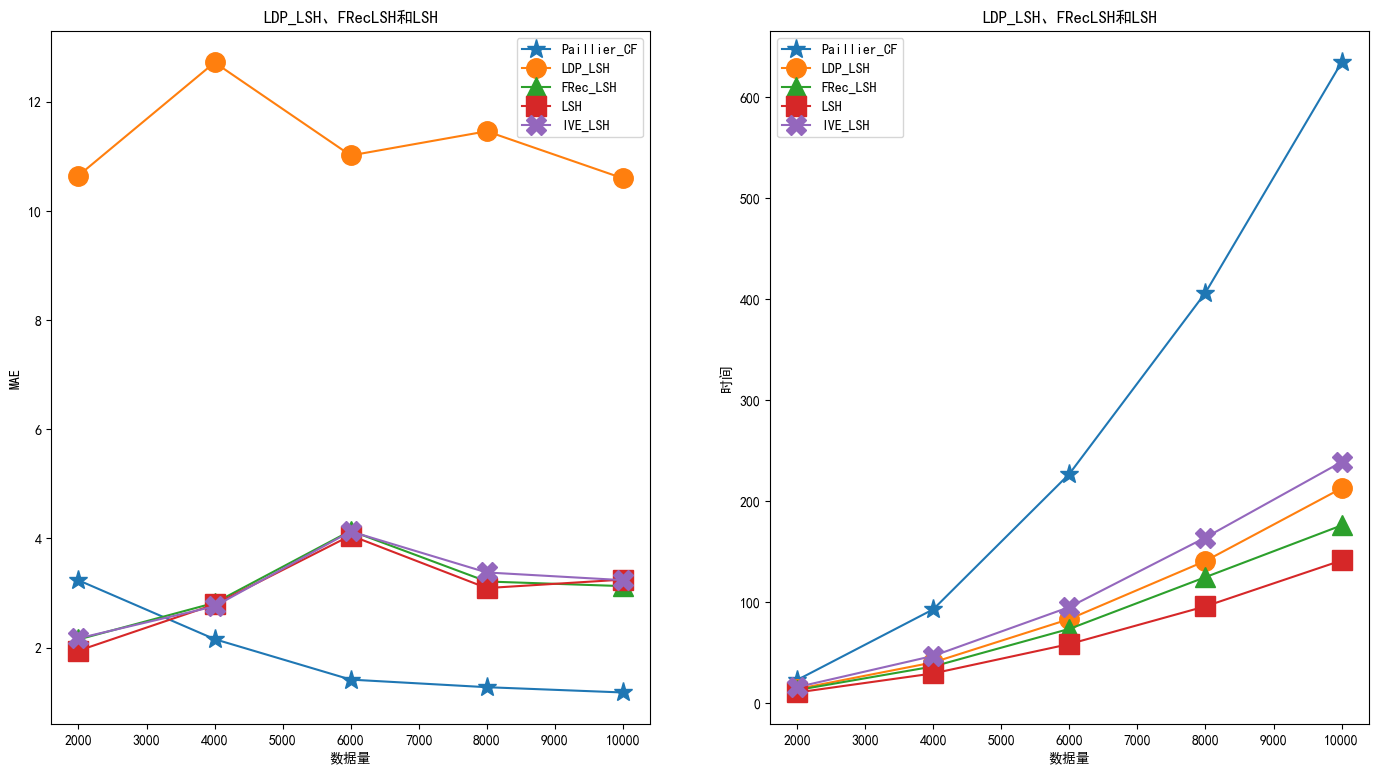

In [14]:
leg = []
leg.append("Paillier_CF"),leg.append("LDP_LSH"),leg.append("FRec_LSH"),leg.append("LSH"),leg.append("IVE_LSH")
print("各个算法的误差为:{0}\n各个所用的时间为{1}".format(bits_dic,times))

style = ["*","o","^","s","X","<",">","p","h","1","2"]
plt.figure(1 , figsize = (17 , 9) )
plt.subplot(121)
for i in range(5):
    plt.plot(data_item,bits_dic[i],marker=style[i],markersize=14)
plt.xlabel("数据量"),plt.ylabel("MAE"),plt.title("LDP_LSH、FRecLSH和LSH"),plt.legend(leg)

plt.subplot(122)
for i in range(5):
    plt.plot(data_item,times[i],marker=style[i],markersize=14)
plt.xlabel("数据量"),plt.ylabel("时间"),plt.title("LDP_LSH、FRecLSH和LSH"),plt.legend(leg)
fig=plt.gcf()
fig.savefig('../GIS_LSH_VE_CF/picture//CF_LSH_ELSH111.jpg',dpi=500)
plt.show()